In [4]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import cv2
from numpy.fft import fft2, ifft2

In [5]:
from math import pi, exp

def gaussian_pdf_2D(x, y, sigma=1):
    exp_term = -(x*x + y*y) / (2.*sigma*sigma)
    const_term = 1/(2*pi*(sigma**2))
    return const_term * exp(exp_term)

def get_gaussian_filter(kernel_size=(3,3), sigma=1):
    if type(kernel_size) == type(1):
        m = n = kernel_size
    else:
        m, n = kernel_size
    if (m%2 != 1) or (n%2 != 1):
        raise Exception("Kernel size must be odd ", kernel_size)
    gaussian_kernel = np.zeros((m,n))
    center_x = (n+1) // 2 -1
    center_y = (m+1) // 2 -1
    for u in range(n):
        for v in range(m):
            gaussian_kernel[v, u] = gaussian_pdf_2D(u-center_x, v-center_y, sigma)
    gaussian_kernel /= gaussian_kernel.sum()
    return gaussian_kernel

In [6]:
def zero_padding(img, size=(1,1)):
    m, n = img.shape
    img_pad = np.zeros((m+2*oy, n+2*ox))
    img_pad[oy:-oy, ox:-ox] = img
    return img_pad

def flip_kernel(kernel):
    return kernel[::-1, ::-1]
    
def convolution_2D(img, kernel, padding=True):
    kernel = flip_kernel(kernel)
    p, q = kernel.shape
    ox = (q-1)//2
    oy = (p-1)//2
    if padding:
        img = zero_padding(img, size=(oy,ox))
        m, n = img.shape
    output_img = np.zeros((m, n))
    for cy in range(oy, m-oy):
        for cx in range(ox, n-ox):
            img_window = img[(cy-oy):(cy+oy)+1:, (cx-ox):(cx+ox)+1]
            output_img[cy, cx] = np.sum(img_window*kernel)
    output_img = output_img[oy:-oy, ox:-ox]
    return output_img

In [7]:
def zero_padding(img, size=(1,1)):
    if type(size) == type(1):
        oy = ox = size
    else:
        oy, ox = size
    m, n = img.shape
    img_pad = np.zeros((m+2*oy, n+2*ox))
    img_pad[oy:-oy, ox:-ox] = img
    return img_pad

def flip_kernel(kernel):
    return kernel[::-1, ::-1]
    
def convolution_2D(img, kernel, padding=True):
    if len(img.shape) != 2:
        raise Exception("Only support gray image right now !", img.shape)
    kernel = flip_kernel(kernel)
    m, n = img.shape
    p, q = kernel.shape
    
    ox = (q-1)//2
    oy = (p-1)//2
    if padding:
        img = zero_padding(img, size=(oy,ox))
        m, n = img.shape
    
    output_img = np.zeros((m, n))
    for cy in range(oy, m-oy):
        for cx in range(ox, n-ox):
            img_window = img[(cy-oy):(cy+oy)+1:, (cx-ox):(cx+ox)+1]
            output_img[cy, cx] = np.sum(img_window*kernel)
            
    output_img = output_img[oy:-oy, ox:-ox]
    return output_img

In [8]:
def subsampling(img, size=(64,64)):
    if len(img.shape) != 2:
        raise Exception("Only support gray image right now !", img.shape)
    m, n = img.shape
    sy = m/size[0]
    sx = n/size[1]
    img_sub = np.zeros(size)
    for row in range(size[0]):
        for col in range(size[1]):
            r = min(row*sy, m-1)
            c = min(col*sx, n-1)
            img_sub[row][col] = img[int(r)][int(c)]
    return img_sub

# def bilinear_interpolation(img, size=(128,128)):
#     pass

def nearest_interpolation(img, size=(128,128)):
    m, n = img.shape
    img_up = np.zeros(size)
    sy = size[0]/m
    sx = size[1]/n
    for y in range(m):
        for x in range(n):
            y_low = int(y*sy)
            y_high = int((y+1)*sy)
            x_low = int(x*sx)
            x_high = int((x+1)*sx)
            img_up[y_low:y_high, x_low:x_high] = img[y,x] 
    return img_up

In [9]:
def image_pyramid(img, gaussian_filter, num_layers=5, ratio=2):
    
    # Gaussian Pyramid
    img_layer = img.copy()
    gaussian_pyramid = [img_layer]
    for i in range(num_layers):
        img_smooth = convolution_2D(img_layer, gaussian_filter)
        m, n = img_layer.shape
        img_layer = subsampling(img_smooth, size=(int(m/ratio), int(n/ratio)))
        gaussian_pyramid.append(img_layer)
    
    # Laplacian Pyramid 
    laplacian_pyramid = []
    for i in range(1, len(gaussian_pyramid)):
        img_high = gaussian_pyramid[i-1]
        img_low = gaussian_pyramid[i]
        img_up = nearest_interpolation(img_low, img_high.shape)
        laplacian = img_high - img_up
        laplacian_pyramid.append(laplacian)

    return gaussian_pyramid, laplacian_pyramid

In [10]:
def fft(channel):
    fft = np.fft.fft2(channel)
    fft /= fft.max()  
    return np.absolute(fft) - 0.5

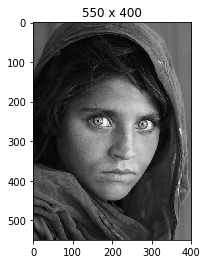

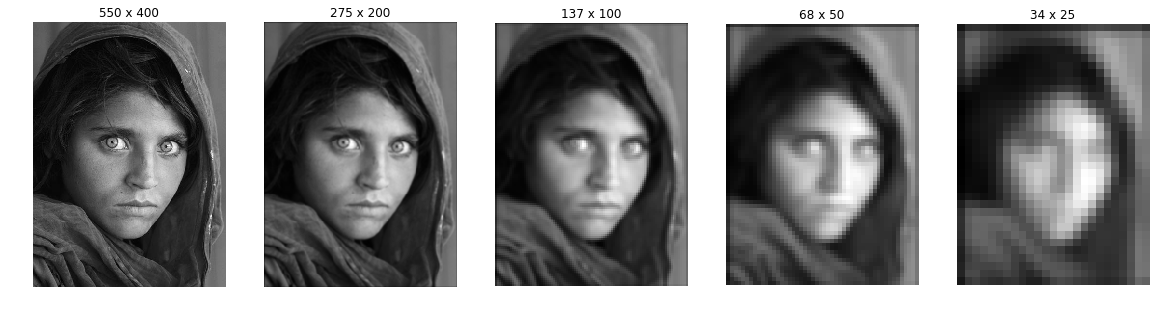

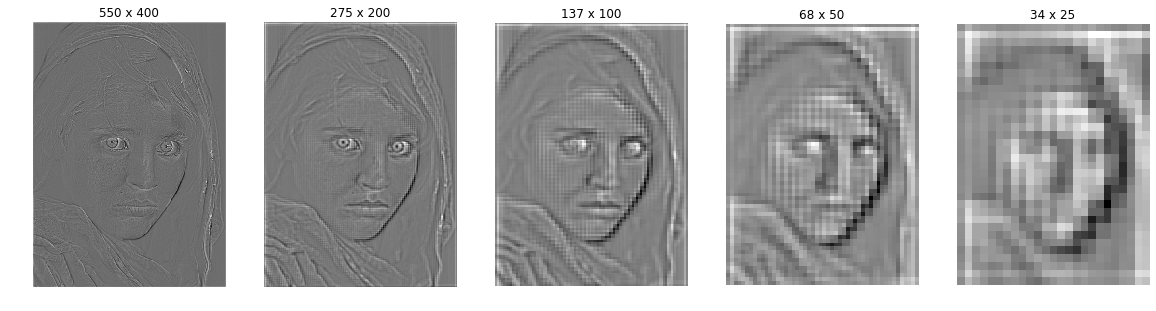

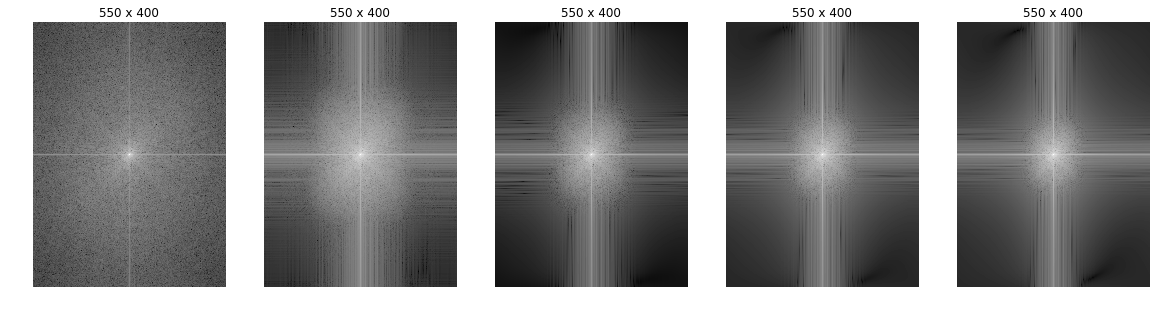

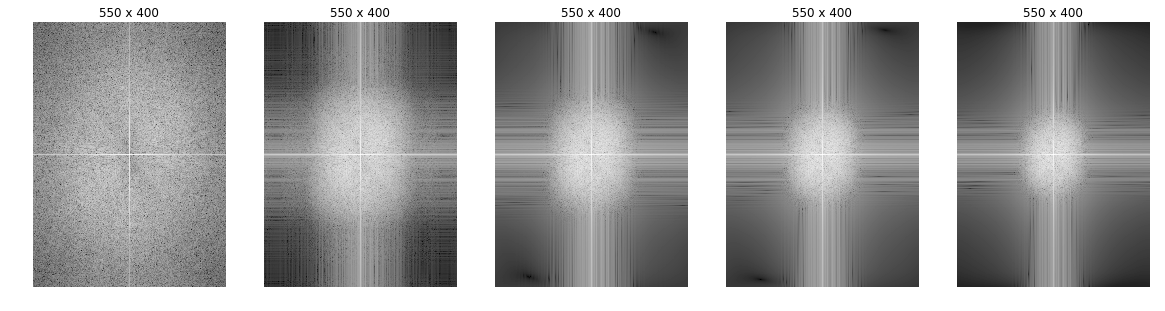

In [11]:
img = cv2.imread("datas/lena.jpg")
img = cv2.imread("datas/Afghan_girl_before.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
plt.imshow(img_gray, cmap='gray'), plt.title("%d x %d"%(img_gray.shape)), plt.show()

gaussian_filter = get_gaussian_filter(kernel_size=(7,7), sigma=1.5)
num_layers = 5
gaussian_pyramid, laplacian_pyramid = image_pyramid(img_gray, gaussian_filter, num_layers, ratio=2)


# Plot Gaussian pyramid
plt.figure(figsize = (20,10))
for i, gaussian in enumerate(gaussian_pyramid[:-1]):
    m, n = gaussian.shape
    plt.subplot(1, num_layers, i+1), plt.axis('off'), 
    plt.title("%d x %d"%(m,n)), plt.imshow(gaussian, cmap='gray')
plt.show()

# Plot Laplacian pyramid
plt.figure(figsize = (20,10))
for i, laplacian in enumerate(laplacian_pyramid):
    m, n = laplacian.shape
    plt.subplot(1, num_layers, i+1), plt.axis('off'), 
    plt.title("%d x %d"%(m,n)), plt.imshow(laplacian, cmap='gray')
plt.show()


gaussian_pyramid, laplacian_pyramid = image_pyramid(img_gray, gaussian_filter, num_layers, ratio=1)
# Plot Gaussian frequency magnitude spectrum
magnitude_spectrums = [] 
lowest = 1e+10
highest = -1e+10
for i, gaussian in enumerate(gaussian_pyramid[:-1]):
    m, n = gaussian.shape
    f = np.fft.fft2(gaussian)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log10(np.abs(fshift))
    magnitude_spectrums.append(magnitude_spectrum)
    lowest = min(lowest, np.nanmin(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
    highest = max(highest, np.nanmax(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
plt.figure(figsize = (20,10))
for i, magnitude_spectrum in enumerate(magnitude_spectrums):
    original_range = highest - lowest
    norm_fourier = (magnitude_spectrum - lowest) / original_range * 255
    plt.subplot(1, num_layers, i+1), plt.axis('off'), 
    plt.title("%d x %d"%(m,n)), plt.imshow(norm_fourier, cmap='gray')
plt.show()


# Plot Laplacian frequency magnitude spectrum
magnitude_spectrums = [] 
lowest = 1e+10
highest = -1e+10
for i, laplacian in enumerate(laplacian_pyramid):
    m, n = laplacian.shape
    f = np.fft.fft2(laplacian)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log10(np.abs(fshift))
    magnitude_spectrums.append(magnitude_spectrum)
    lowest = min(lowest, np.nanmin(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
    highest = max(highest, np.nanmax(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
plt.figure(figsize = (20,10))
for i, magnitude_spectrum in enumerate(magnitude_spectrums):
    original_range = highest - lowest
    norm_fourier = (magnitude_spectrum - lowest) / original_range * 255
    plt.subplot(1, num_layers, i+1), plt.axis('off'), 
    plt.title("%d x %d"%(m,n)), plt.imshow(norm_fourier, cmap='gray')
plt.show()

In [25]:
import glob
img_names = glob.glob('datas/*')
import os

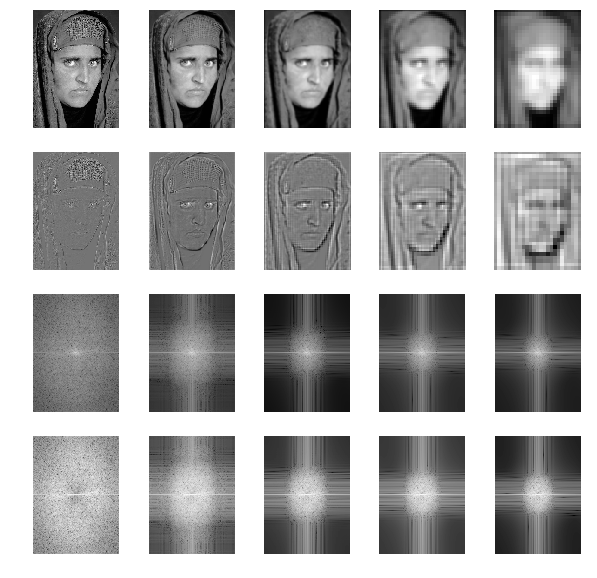

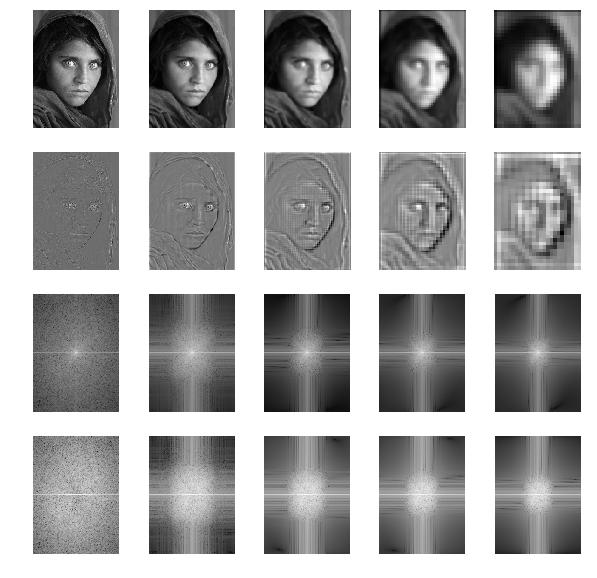

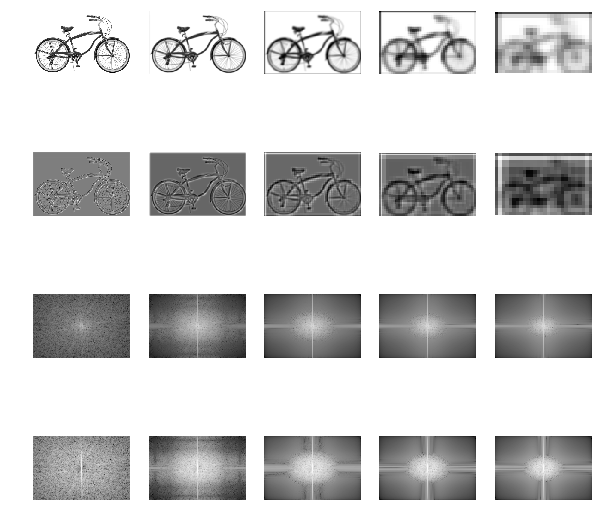

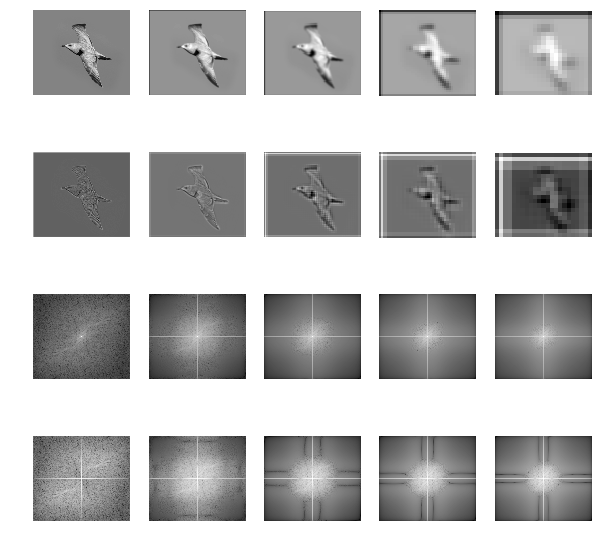

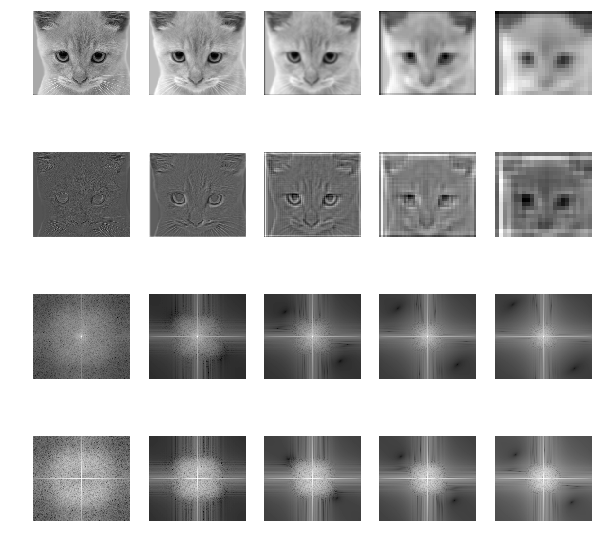

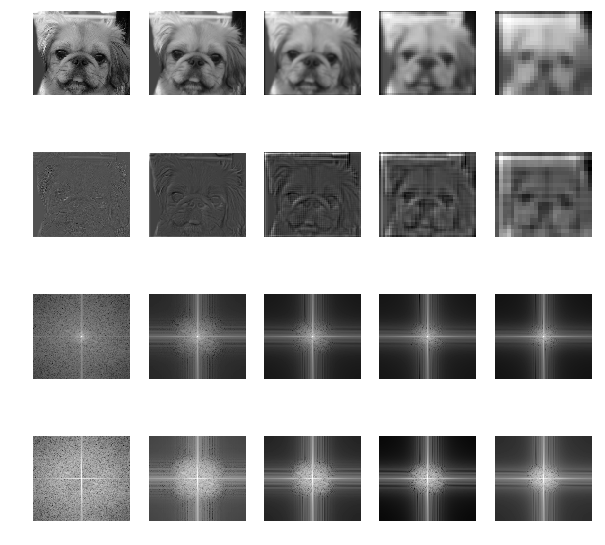

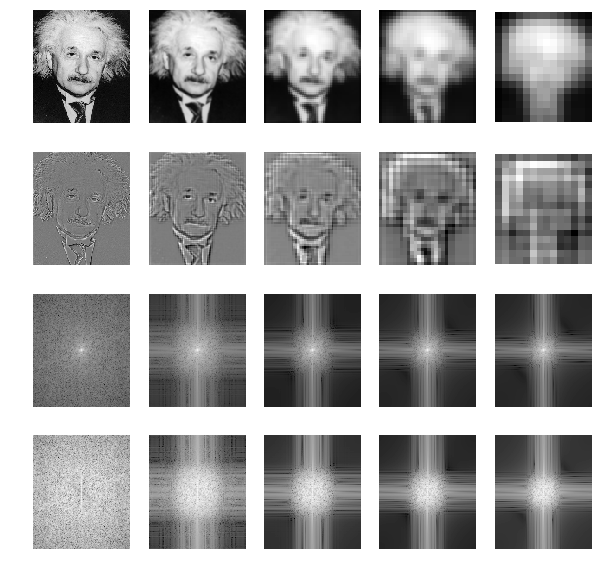

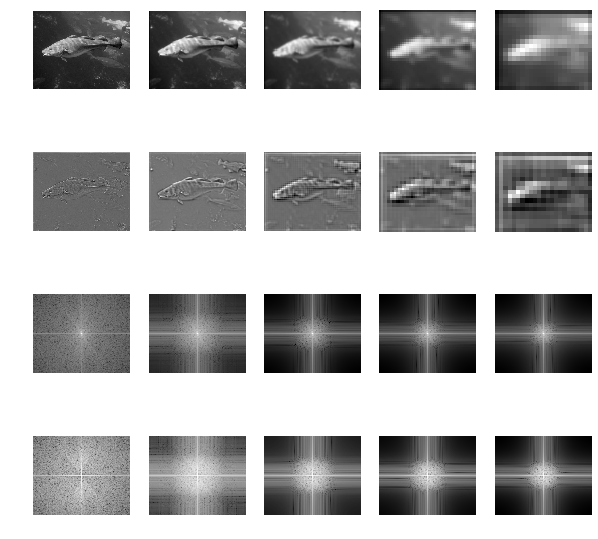

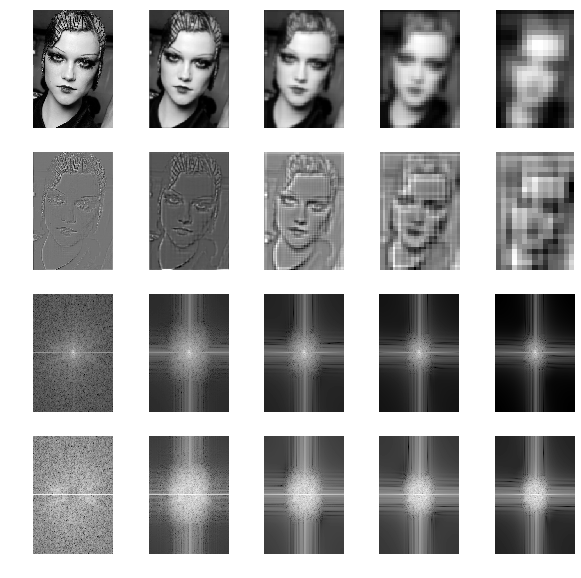

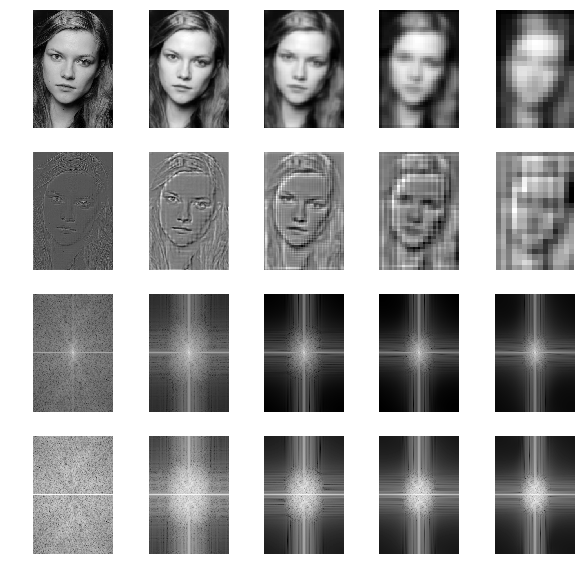

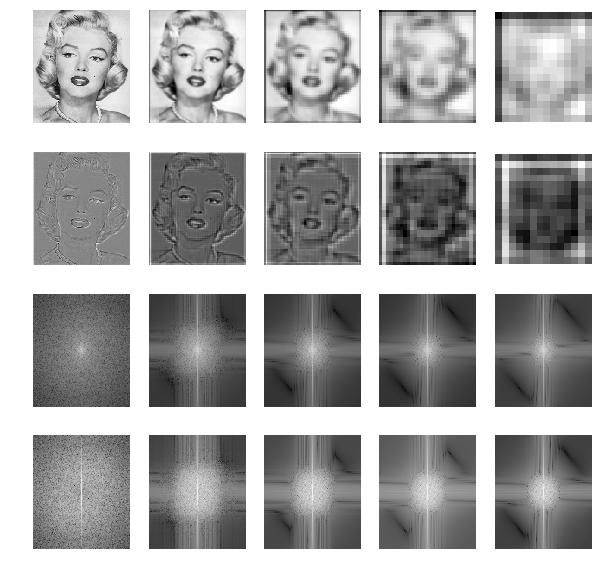

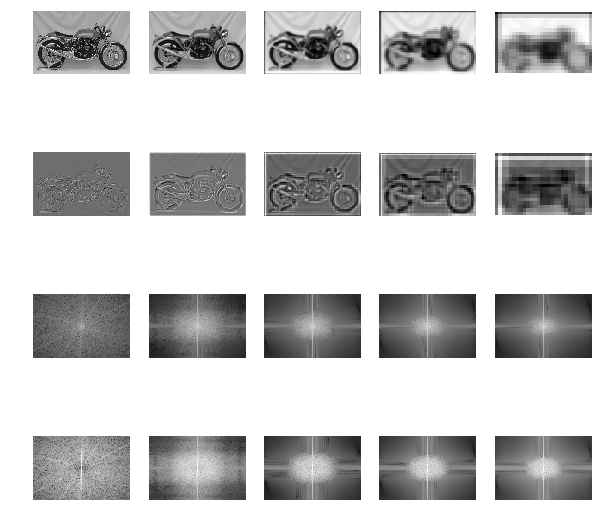

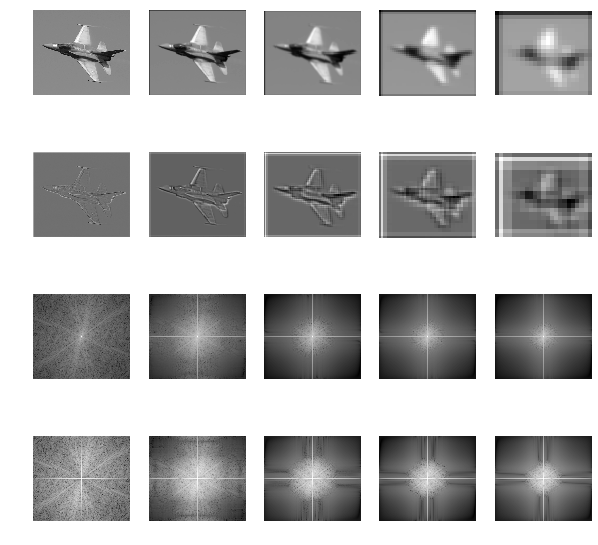

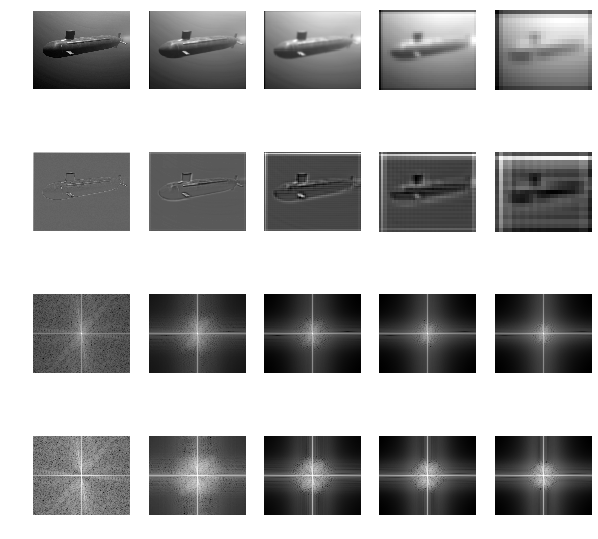

In [28]:
for img_name in img_names:
    img = cv2.imread(img_name)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

    gaussian_filter = get_gaussian_filter(kernel_size=(7,7), sigma=1.5)
    num_layers = 5
    gaussian_pyramid, laplacian_pyramid = image_pyramid(img_gray, gaussian_filter, num_layers, ratio=2)

    # Plot Gaussian pyramid
    plt.figure(figsize = (10,10))
    plt.tight_layout()
    for i, gaussian in enumerate(gaussian_pyramid[:-1]):
        m, n = gaussian.shape
        plt.subplot(4, num_layers, i+1), plt.axis('off'), 
        plt.imshow(gaussian, cmap='gray')

    # Plot Laplacian pyramid
    for i, laplacian in enumerate(laplacian_pyramid):
        m, n = laplacian.shape
        plt.subplot(4, num_layers, i+1+5), plt.axis('off'), 
        plt.imshow(laplacian, cmap='gray')


    gaussian_pyramid, laplacian_pyramid = image_pyramid(img_gray, gaussian_filter, num_layers, ratio=1)
    # Plot Gaussian frequency magnitude spectrum
    magnitude_spectrums = [] 
    lowest = 1e+10
    highest = -1e+10
    for i, gaussian in enumerate(gaussian_pyramid[:-1]):
        m, n = gaussian.shape
        f = np.fft.fft2(gaussian)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.log10(np.abs(fshift))
        magnitude_spectrums.append(magnitude_spectrum)
        lowest = min(lowest, np.nanmin(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
        highest = max(highest, np.nanmax(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
    for i, magnitude_spectrum in enumerate(magnitude_spectrums):
        original_range = highest - lowest
        norm_fourier = (magnitude_spectrum - lowest) / original_range * 255
        plt.subplot(4, num_layers, i+1+10), plt.axis('off'), 
        plt.imshow(norm_fourier, cmap='gray')


    # Plot Laplacian frequency magnitude spectrum
    magnitude_spectrums = [] 
    lowest = 1e+10
    highest = -1e+10
    for i, laplacian in enumerate(laplacian_pyramid):
        m, n = laplacian.shape
        f = np.fft.fft2(laplacian)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.log10(np.abs(fshift))
        magnitude_spectrums.append(magnitude_spectrum)
        lowest = min(lowest, np.nanmin(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
        highest = max(highest, np.nanmax(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
    for i, magnitude_spectrum in enumerate(magnitude_spectrums):
        original_range = highest - lowest
        norm_fourier = (magnitude_spectrum - lowest) / original_range * 255
        plt.subplot(4, num_layers, i+1+15), plt.axis('off'), 
        plt.imshow(norm_fourier, cmap='gray')
    
    base=os.path.basename(img_name)
    file_name = os.path.splitext(base)[0] + '.jpg'
    plt.savefig('results/' + file_name)